# Principal Component Analysis Kalman Residual Z-Score Strategy

## Packages

In [3]:
import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
sys.path.append(r"/Users/diegoalvarez/Desktop/research/TreasuryKalmanResidualPC/root/src")
sys.path.append(r"C:\Users\Diego\Desktop\app_prod\research\TreasuryKalmanResidualPC\root\src")
from Backtest import Backtest

# Average Return Portfolio

In [6]:
df = Backtest().get_avg_rtn()

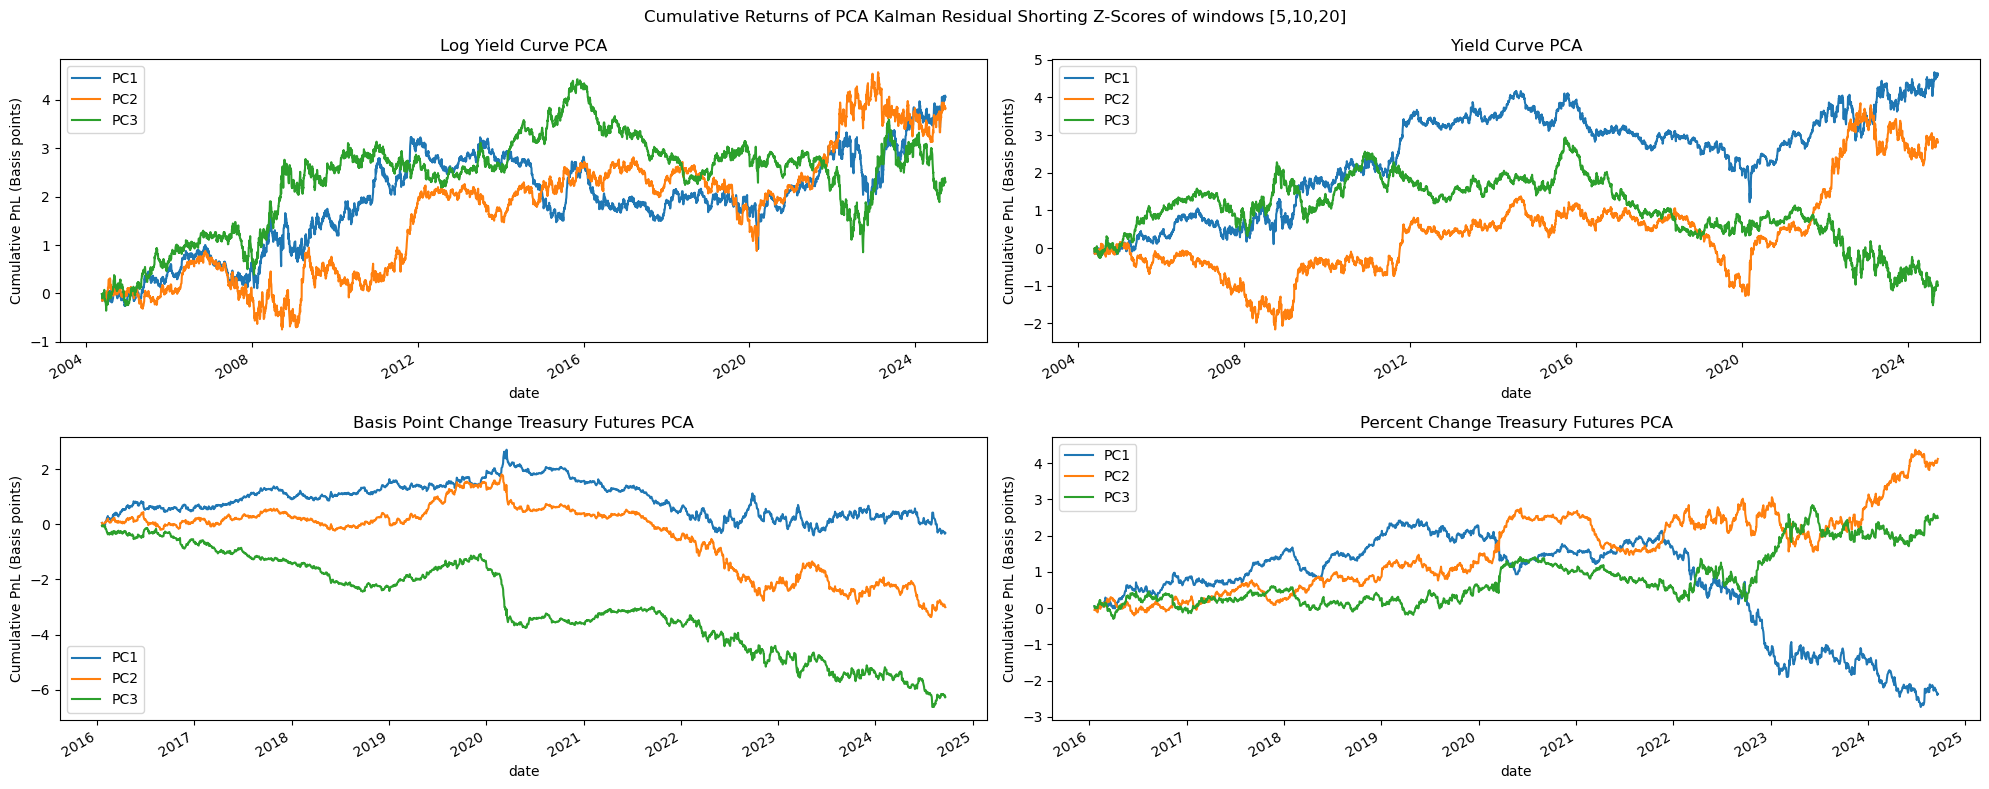

In [7]:
def plot_return(df: pd.DataFrame) -> plt.Figure: 

    group_vars = {
        "log_yld": "Log Yield Curve PCA",
        "yld"    : "Yield Curve PCA",
        "PX_bps" : "Basis Point Change Treasury Futures PCA",
        "PX_pct" : "Percent Change Treasury Futures PCA"}
    
    fig, axes  = plt.subplots(
        ncols   = len(group_vars.keys()) // 2, 
        nrows   = len(group_vars.keys()) // 2, 
        figsize = (20,8))
    
    for group_var, ax in zip(group_vars.keys(), axes.flatten()): 
    
        (df.query(
            "input_var == @group_var").
            drop(columns = ["input_var"]).
            rename(columns = {"variable": ""}).
            pivot(index = "date", columns = "", values = "signal_rtn").
            cumsum().
            plot(
                ax     = ax,
                ylabel = "Cumulative PnL (Basis points)",
                title  = group_vars[group_var]))

    fig.suptitle("Cumulative Returns of PCA Kalman Residual Shorting Z-Scores of windows [5,10,20]")
    plt.tight_layout()
    

plot_return(df)

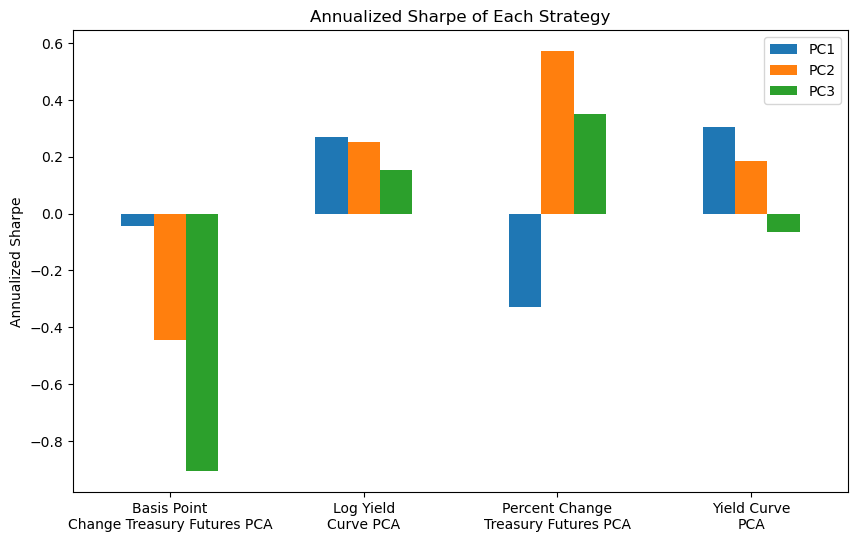

In [8]:
def plot_sharpe(df: pd.DataFrame) -> plt.Figure: 

    fig, axes = plt.subplots(figsize = (10,6))
    
    group_vars = {
        "log_yld": "Log Yield\nCurve PCA",
        "yld"    : "Yield Curve\nPCA",
        "PX_bps" : "Basis Point\nChange Treasury Futures PCA",
        "PX_pct" : "Percent Change\nTreasury Futures PCA"}
    
    df_namer = (pd.DataFrame.from_dict(
        data = group_vars,
        orient = "index").
        rename(columns = {0: "strat"}).
        reset_index().
        rename(columns = {"index": "input_var"}))
    
    (df.drop(
        columns = ["date"]).
        merge(right = df_namer, how = "inner", on = ["input_var"]).
        drop(columns = ["input_var"]).
        groupby(["strat", "variable"]).
        agg(["mean", "std"])
        ["signal_rtn"].
        rename(columns = {
            "mean": "mean_rtn",
            "std" : "std_rtn"}).
        assign(sharpe = lambda x: x.mean_rtn / x.std_rtn * np.sqrt(252)).
        reset_index()
        [["strat", "variable", "sharpe"]].
        rename(columns = {"variable": ""}).
        pivot(index = "strat", columns = "", values = "sharpe").
        plot(
            ax      = axes,
            kind    = "bar",
            xlabel  = "",
            title   = "Annualized Sharpe of Each Strategy",
            ylabel  = "Annualized Sharpe"))
    
    for tick in axes.get_xticklabels(): tick.set_rotation(0)

plot_sharpe(df)

## Inverse Volatility Scaling Portfolio

In [10]:
def get_erc() -> pd.DataFrame: 

    df = Backtest().get_erc_portfolio()
    
    df_out = (df[
        ["date", "port", "weighted_rtn"]].
        groupby(["date", "port"]).
        agg("sum").
        reset_index().
        rename(columns = {"weighted_rtn": "signal_rtn"}).
        assign(
            input_var = lambda x: x.port.str.split(" ").str[0],
            variable  = lambda x: x.port.str.split(" ").str[-1]).
        drop(columns = ["port"]))

    return df_out

df = get_erc()

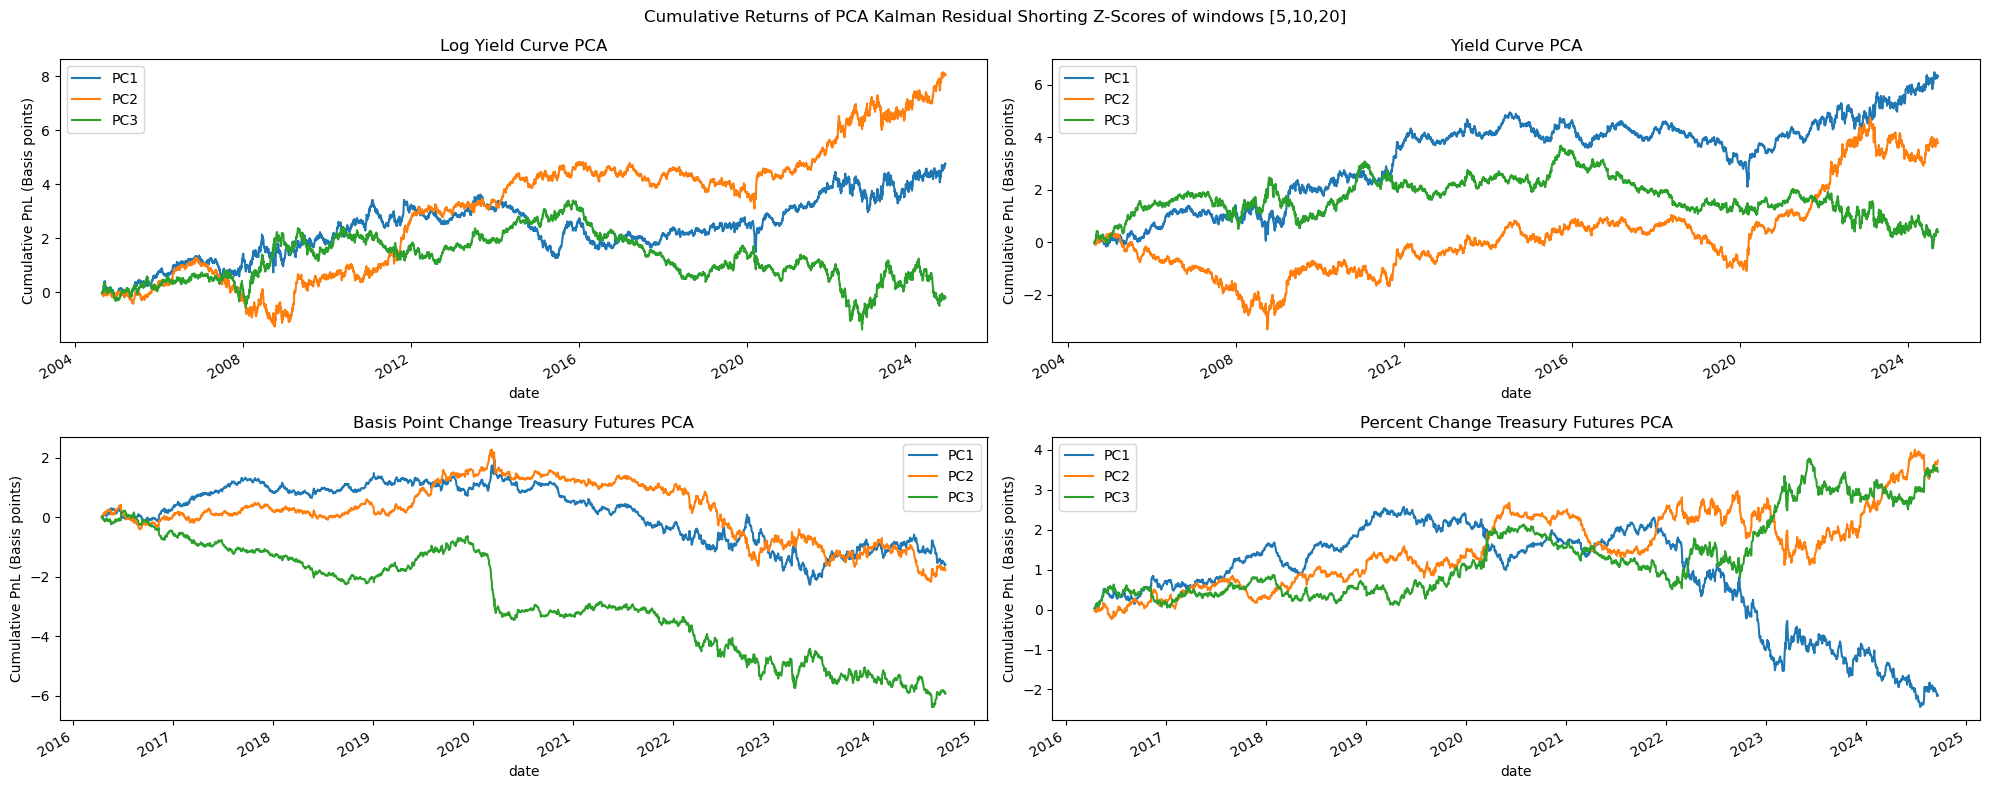

In [11]:
plot_return(df)

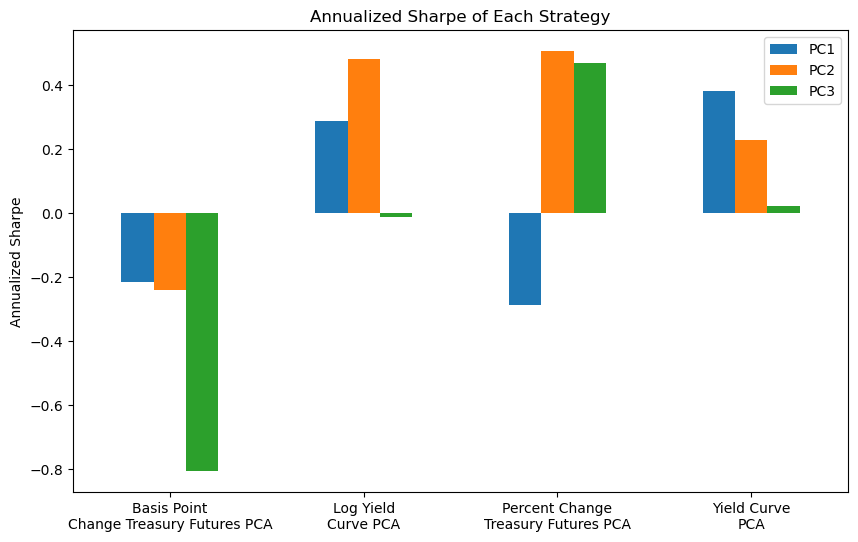

In [12]:
plot_sharpe(df)

# Rolling Sharpe Maximization Strategy

Just average them across each strategy (they are in basis points)

In [15]:
def get_max_roll_sharpe_avg() -> pd.DataFrame: 

    df_out = (Backtest().get_max_sharpe().drop(
        columns = ["window", "lag_sharpe", "security", "signal"]).
        groupby(["date", "input_var", "variable"]).
        agg("mean").
        reset_index())

    return df_out

df_max_sharpe = get_max_roll_sharpe_avg()

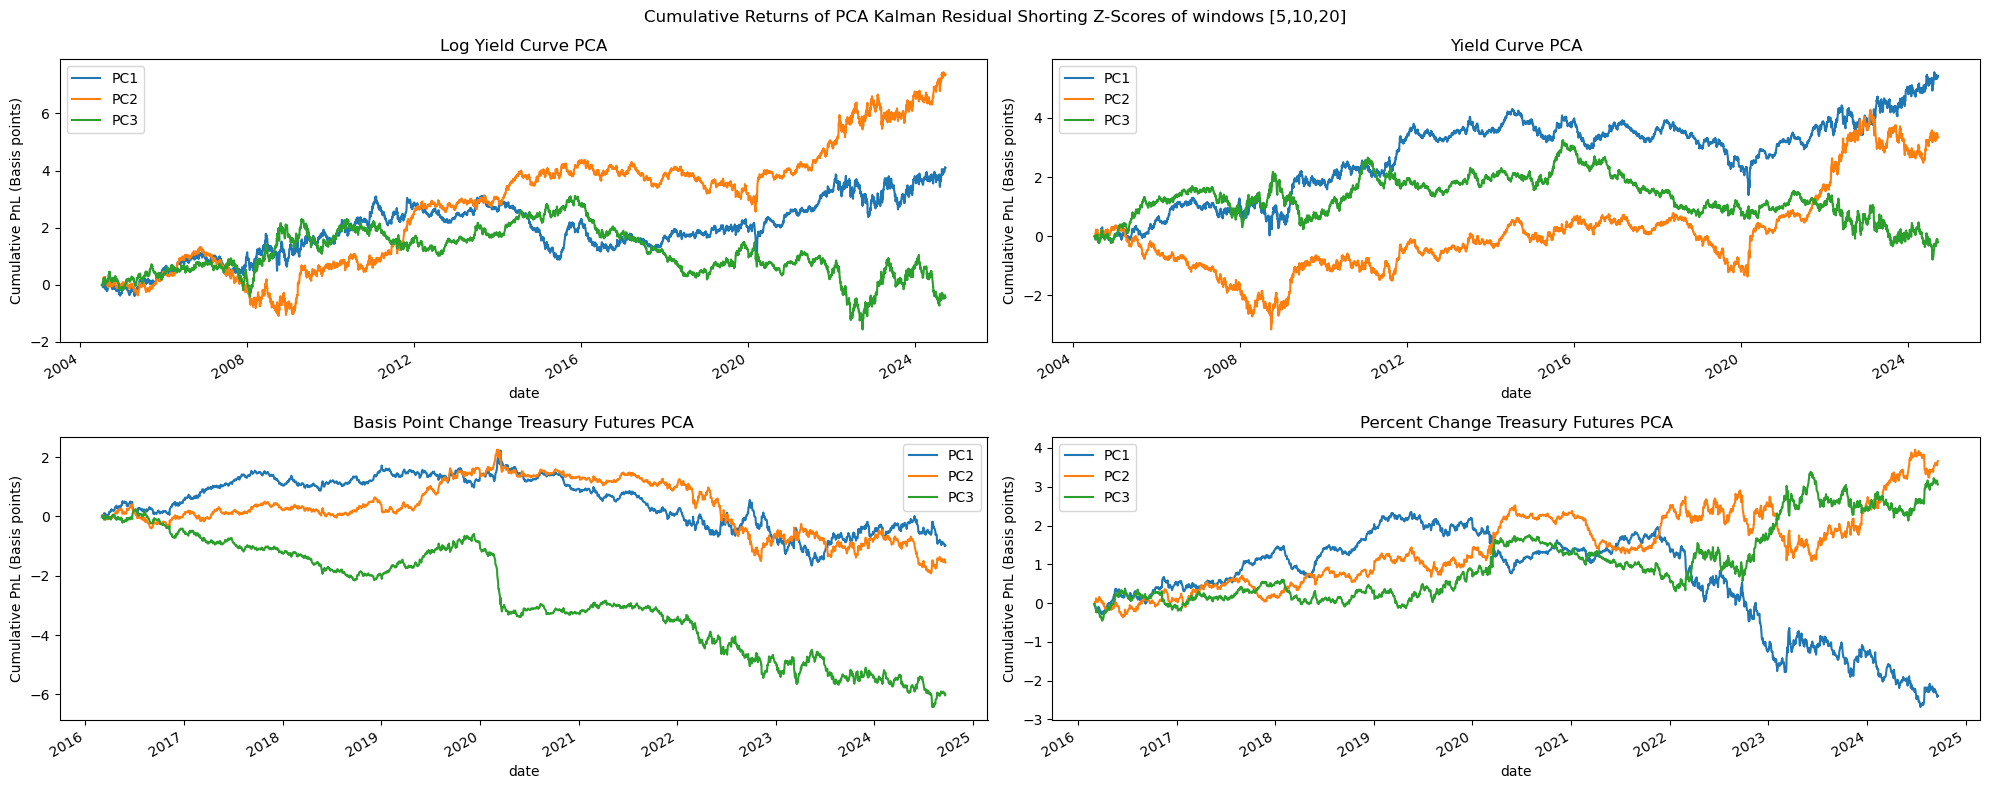

In [16]:
plot_return(df_max_sharpe)

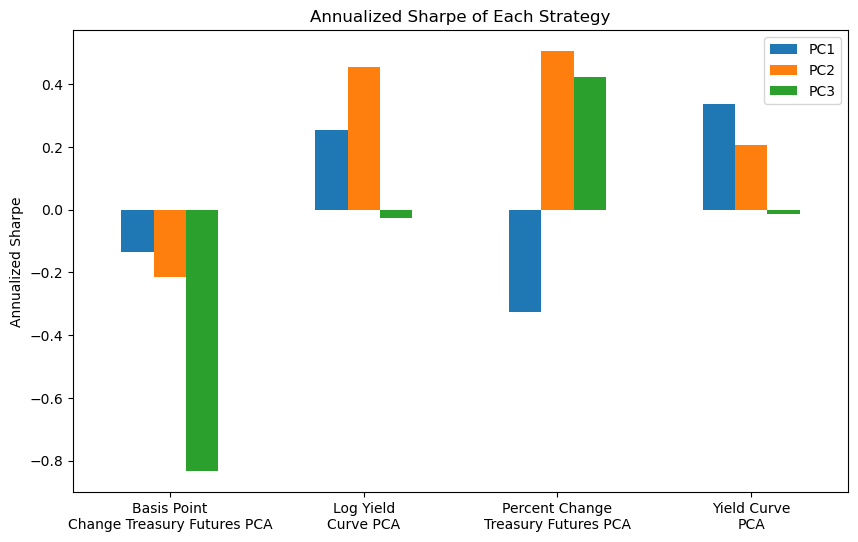

In [17]:
plot_sharpe(df_max_sharpe)